In [3]:
import pandas as pd

# Prescription

In [4]:
prescription_result = pd.read_csv("./data/llama_output/prescription_output.csv")

In [5]:
prescription_result.head()

,Unnamed: 0,instruction,output,generated_text
0,0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te..."
1,1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te..."
2,2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te..."
3,3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te..."
4,4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te..."


In [6]:
sample = prescription_result["generated_text"][0]

In [7]:
sample

"{'start_index': '514', 'end_index': '525', 'text': 'lamotrigine', 'attributes': {'DrugName': 'Lamotrigine', 'DrugDose': '150', 'DoseUnit':'mg', 'Frequency': '2'}} {'start_index': '567', 'end_index': '578', 'text': 'lamotrigine', 'attributes': {'DrugName': 'Lamotrigine', 'DrugDose"

In [27]:
# !pip install -q -U google-generativeai

In [ ]:
api_key = ""

In [9]:
import google.generativeai as genai
import os
from google.generativeai.types import HarmCategory, HarmBlockThreshold

genai.configure(api_key=api_key)

In [10]:
model = genai.GenerativeModel("gemini-1.5-flash")

In [11]:
import time
from tqdm import tqdm

In [12]:
def get_modified(x):
    prompt = f'''
        Given the below JSON, please extract the valid JSON and respond only 1 json file that is valid
        {x}
    '''
    response = model.generate_content(
        prompt, 
        safety_settings={
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
            }
        )
    time.sleep(10)
    return response.text

In [13]:
tqdm.pandas()

In [14]:
prescription_result["gemini_flash"] = prescription_result["generated_text"].progress_apply(lambda x: get_modified(x))

100%|██████████| 30/30 [05:20<00:00, 10.69s/it]


In [15]:
from ast import literal_eval

In [16]:
def fix_data(x):
    return literal_eval(x.replace("json", "").replace("```", "").replace("\n", ""))

prescription_result['gemini_flash'] = prescription_result["gemini_flash"].progress_apply(lambda x: fix_data(x))

100%|██████████| 30/30 [00:00<?, ?it/s]


In [17]:
prescription_result.drop(columns=["Unnamed: 0"], axis=0, inplace=True)

In [18]:
prescription_result.head()

,instruction,output,generated_text,gemini_flash
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te..."
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te..."
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te..."
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te..."
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te..."


In [71]:
prescription_result["generated_text"][20]

"{'start_index': '173', 'end_index': '189', 'text': 'Sodium valproate', 'attributes': {'DrugName': 'SodiumValproate', 'DrugDose': '1000', 'DoseUnit':'mg', 'Frequency': '2'}} {'start_index': '196', 'end_index': '213', 'text': 'Briviteracetam 50mg bd', 'attributes': {'DrugName': 'Brivaracet"

In [72]:
prescription_result["output"][20]

"{'start_index': '153', 'end_index': '169', 'text': 'Sodium valproate', 'attributes': {'DrugName': 'SodiumValproate', 'DrugDose': '1000', 'DoseUnit': 'mg', 'Frequency': '2'}}"

In [19]:
prescription_result.to_csv("prescription_result_processed.csv", index=True)

In [20]:
literal_eval(prescription_result["output"][0])

{'start_index': '547',
 'end_index': '558',
 'text': 'lamotrigine',
 'attributes': {'DrugName': 'Lamotrigine',
  'DrugDose': '150',
  'DoseUnit': 'mg',
  'Frequency': '2'}}

In [21]:
prescription_result["gemini_flash"][0]

{'start_index': '514',
 'end_index': '525',
 'text': 'lamotrigine',
 'attributes': {'DrugName': 'Lamotrigine',
  'DrugDose': '150',
  'DoseUnit': 'mg',
  'Frequency': '2'}}

In [22]:
import numpy as np
import sklearn.metrics

In [23]:
def get_metrics(y_true, y_pred):
    print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))

    print('Hamming loss: {0:.2f}'.format(sklearn.metrics.hamming_loss(y_true, y_pred)))

    print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, average='samples'))) 

    print('Precision: {0:.2f}'.format(sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, average='samples')))

    print('F1 Measure: {0:.2f}'.format(sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, average='samples')))

In [24]:
def _convert_to_bool_keys(pred, gt):
    if not isinstance(gt, dict):
        gt = literal_eval(gt)
    
    keys_gt = list(gt.keys())
    if "attributes" in gt:
        keys_gt += list(map(lambda x: f"attributes_{x}", gt["attributes"].keys()))
    
    keys_pred = list(pred.keys())
    if "attributes" in pred:
        keys_pred += list(map(lambda x: f"attributes_{x}", gt["attributes"].keys()))

    unique_keys_gt = set(keys_gt)
    unique_keys_pred = set(keys_pred)

    gt_arr = np.ones((len(unique_keys_gt,)))
    pred_arr = []
    for key in unique_keys_gt:
        if key in unique_keys_pred:
            pred_arr.append(1)
        else:
            pred_arr.append(0)
    pred_arr = np.asarray(pred_arr)

    gt_arr = gt_arr.reshape(1, gt_arr.shape[0])
    pred_arr = pred_arr.reshape(1, pred_arr.shape[0])
    return gt_arr, pred_arr

In [25]:
y_true = np.array([])
y_pred = np.array([])

for _y_pred, _y_true in zip(prescription_result["gemini_flash"], prescription_result["output"]): 
    _y_true, _y_pred = _convert_to_bool_keys(_y_pred, _y_true)

    if y_true.shape[0] == 0:
        y_true = _y_true
    else:
        y_true = np.vstack((y_true, _y_true))
    
    if y_pred.shape[0] == 0:
        y_pred = _y_pred 
    else:
        y_pred = np.vstack((y_pred, _y_pred))

In [26]:
get_metrics(y_true, y_pred)

Exact Match Ratio: 1.0
Hamming loss: 0.00
Recall: 1.0
Precision: 1.00
F1 Measure: 1.00


In [27]:
def _convert_to_bool_values(pred, gt):
    if not isinstance(gt, dict):
        gt = literal_eval(gt)
    
    tmp_gt = gt.copy()
    if "attributes" in tmp_gt:
        del tmp_gt["attributes"]
    
    values_gt = list(tmp_gt.values())
    if "attributes" in gt:
        values_gt += list(map(lambda x: f"attributes_{x}", gt["attributes"].values()))
    
    tmp_pred = pred.copy()
    if "attributes" in tmp_pred:
        del tmp_pred["attributes"]

    values_pred = list(tmp_pred.values())
    if "attributes" in pred:
        values_pred += list(map(lambda x: f"attributes_{x}", gt["attributes"].values()))

    unique_values_gt = set(values_gt)
    unique_values_pred = set(values_pred)

    gt_arr = np.ones((len(unique_values_gt,)))
    pred_arr = []
    for key in unique_values_gt:
        if key in unique_values_pred:
            pred_arr.append(1)
        else:
            pred_arr.append(0)
    pred_arr = np.asarray(pred_arr)

    gt_arr = gt_arr.reshape(1, gt_arr.shape[0])
    pred_arr = pred_arr.reshape(1, pred_arr.shape[0])
    return gt_arr, pred_arr

In [28]:
_convert_to_bool_values(prescription_result["gemini_flash"][0], prescription_result["output"][0])

(array([[1., 1., 1., 1., 1., 1., 1.]]), array([[1, 0, 1, 1, 1, 1, 0]]))

In [29]:
y_true = np.array([])
y_pred = np.array([])

for _y_pred, _y_true in zip(prescription_result["gemini_flash"], prescription_result["output"]): 
    _y_true, _y_pred = _convert_to_bool_values(_y_pred, _y_true)

    if y_true.shape[0] == 0:
        y_true = _y_true
    else:
        y_true = np.vstack((y_true, _y_true))
    
    if y_pred.shape[0] == 0:
        y_pred = _y_pred 
    else:
        y_pred = np.vstack((y_pred, _y_pred))

In [30]:
get_metrics(y_pred, y_true)

Exact Match Ratio: 0.0
Hamming loss: 0.38
Recall: 0.6190476190476192
Precision: 1.00
F1 Measure: 0.76


In [31]:
prescription_result.head()

,instruction,output,generated_text,gemini_flash
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te..."
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te..."
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te..."
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te..."
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te..."


In [32]:
prescription_result["generated_text_string"] = prescription_result["gemini_flash"].apply(lambda x: x["text"])
prescription_result["output_text_string"] = prescription_result["output"].apply(lambda x: literal_eval(x)["text"])


prescription_result.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te...",lamotrigine,lamotrigine
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te...",Lamotrigine 150mg bd,She is taking Lamotrigine 150 mg bd with no si...
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te...",Lamotrigine 150mg bd,Medication: Lamotrigine 150mg bd
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te...",Sodium Valproate,Sodium Valproate
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te...",Sodium Valproate 700mg in the morning,Sodium Valproate


In [164]:
def levenshtein_distance(s1, s2):
    """Calculates the Levenshtein distance between two strings.

    Args:
        s1: The first string.
        s2: The second string.

    Returns:
        The Levenshtein distance between the two strings.
    """

    if len(s1) == 0:
        return len(s2)
    if len(s2) == 0:
        return len(s1)

    if s1[-1] == s2[-1]:
        cost = 0
    else:
        cost = 1

    return min(
        levenshtein_distance(s1[:-1], s2) + 1,
        levenshtein_distance(s1, s2[:-1]) + 1,
        levenshtein_distance(s1[:-1], s2[:-1]) + cost
    )

In [180]:
def levenshtein_distance_vectorized(s1, s2):
    """Calculates the Levenshtein distance using vectorization.

    Args:
        s1: The first string.
        s2: The second string.

    Returns:
        The Levenshtein distance between the two strings.
    """

    m, n = len(s1), len(s2)
    dp = np.zeros((m + 1, n + 1))

    for i in range(1, m + 1):
        dp[i, 0] = i
    for j in range(1, n + 1):
        dp[0, j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            dp[i, j] = min(
                dp[i - 1, j] + 1,
                dp[i, j - 1] + 1,
                dp[i - 1, j - 1] + (s1[i - 1] != s2[j - 1])
            )

    return dp[m, n]

In [195]:
def hamming_distance_vectorized(s1, s2):
    """Calculates the Hamming distance between two strings using vectorization.

    Args:
        s1: The first string.
        s2: The second string.

    Returns:
        The Hamming distance between the two strings.
    """

    if len(s1) != len(s2):
        if len(s1) < len(s2):
            s2 = s2[:len(s1)]
        elif len(s1) > len(s2):
            s1 = s1[:len(s2)] 

    return np.count_nonzero(np.array(list(s1)) != np.array(list(s2)))

In [199]:
def smith_waterman_vectorized(s1, s2, match_score=2, mismatch_score=-1, gap_penalty=-1):
    """Calculates the similarity between two strings using the Smith-Waterman algorithm with vectorization.

    Args:
        s1: The first string.
        s2: The second string.
        match_score: The score for a match.
        mismatch_score: The score for a mismatch.
        gap_penalty: The penalty for a gap.

    Returns:
        A tuple containing the maximum similarity score and the optimal alignment.
    """

    m, n = len(s1), len(s2)
    dp = np.zeros((m + 1, n + 1))

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = dp[i - 1, j - 1] + (match_score if s1[i - 1] == s2[j - 1] else mismatch_score)
            delete = dp[i - 1, j] + gap_penalty
            insert = dp[i, j - 1] + gap_penalty
            dp[i, j] = np.maximum([match, delete, insert])

    max_score = np.max(dp)
    max_i, max_j = np.unravel_index(np.argmax(dp), dp.shape)

    # Backtracking to find the optimal alignment
    alignment1 = ""
    alignment2 = ""
    while max_i > 0 and max_j > 0:
        if dp[max_i, max_j] == dp[max_i - 1, max_j - 1] + (match_score if s1[max_i - 1] == s2[max_j - 1] else mismatch_score):
            alignment1 = s1[max_i - 1] + alignment1
            alignment2 = s2[max_j - 1] + alignment2
            max_i -= 1
            max_j -= 1
        elif dp[max_i, max_j] == dp[max_i - 1, max_j] + gap_penalty:
            alignment1 = s1[max_i - 1] + alignment1
            alignment2 = "-" + alignment2
            max_i -= 1
        else:
            alignment1 = "-" + alignment1
            alignment2 = s2[max_j - 1] + alignment2
            max_j -= 1

    return max_score, alignment1, alignment2

In [191]:
def sorensen_dice_coefficient_vectorized(s1, s2):
    """Calculates the Sorensen-Dice coefficient between two strings using vectorization.

    Args:
        s1: The first string.
        s2: The second string.

    Returns:
        The Sorensen-Dice coefficient between the two strings.
    """

    s1_set = set(s1)
    s2_set = set(s2)
    intersection_size = len(s1_set & s2_set)
    union_size = len(s1_set | s2_set)
    return (2 * intersection_size) / union_size

In [201]:
prescription_result["levenshtein_dist"] = [levenshtein_distance_vectorized(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], prescription_result["output_text_string"])]
prescription_result["hamming_dist"] = [hamming_distance_vectorized(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], prescription_result["output_text_string"])]
# prescription_result["smith_waterman"] = [smith_waterman_vectorized(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], prescription_result["output_text_string"])]
prescription_result["sorensen_dice_coefficient"] = [sorensen_dice_coefficient_vectorized(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], prescription_result["output_text_string"])]

In [33]:
prescription_result.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te...",lamotrigine,lamotrigine
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te...",Lamotrigine 150mg bd,She is taking Lamotrigine 150 mg bd with no si...
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te...",Lamotrigine 150mg bd,Medication: Lamotrigine 150mg bd
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te...",Sodium Valproate,Sodium Valproate
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te...",Sodium Valproate 700mg in the morning,Sodium Valproate


In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

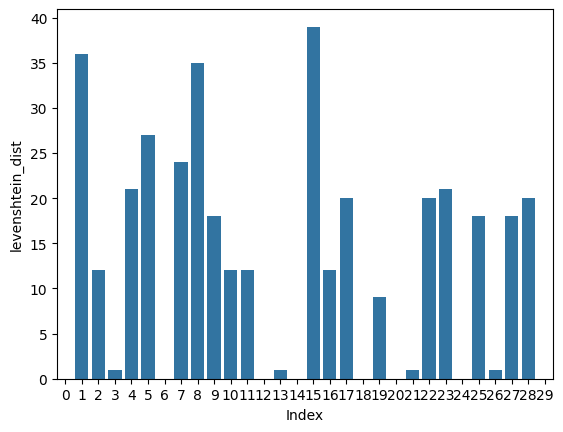

In [209]:
sns.barplot(x=prescription_result.index, y=prescription_result["levenshtein_dist"])
plt.xlabel("Index")
plt.show()

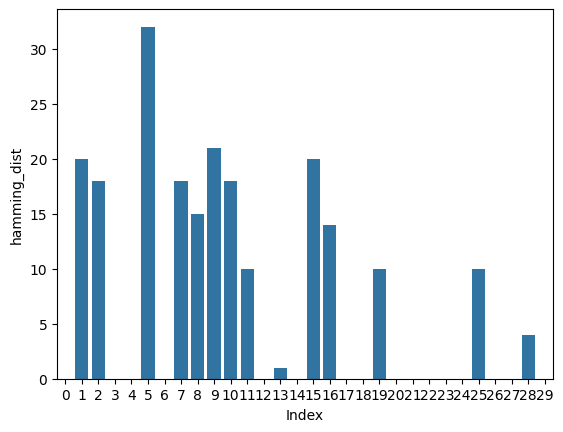

In [210]:
sns.barplot(x=prescription_result.index, y=prescription_result["hamming_dist"])
plt.xlabel("Index")
plt.show()

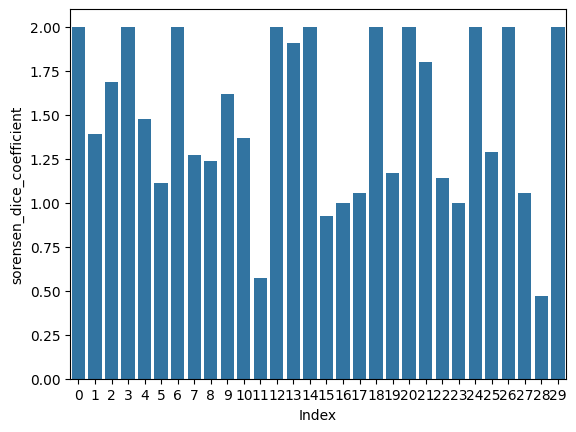

In [211]:
sns.barplot(x=prescription_result.index, y=prescription_result["sorensen_dice_coefficient"])
plt.xlabel("Index")
plt.show()

In [216]:
def smith_waterman(s1, s2, match_score=2, mismatch_score=-1, gap_penalty=-1):
    """Calculates the similarity between two strings using the Smith-Waterman algorithm.

    Args:
        s1: The first string.
        s2: The second string.
        match_score: The score for a match.
        mismatch_score: The score for a mismatch.
        gap_penalty: The penalty for a gap.

    Returns:
        A tuple containing the maximum similarity score and the optimal alignment.
    """

    m = len(s1)
    n = len(s2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = dp[i - 1][j - 1] + (match_score if s1[i - 1] == s2[j - 1] else mismatch_score)
            delete = dp[i - 1][j] + gap_penalty
            insert = dp[i][j - 1] + gap_penalty
            dp[i][j] = max(match, delete, insert, 0)

    max_score = 0
    max_i = 0
    max_j = 0
    for i in range(m + 1):
        for j in range(n + 1):
            if dp[i][j] > max_score:
                max_score = dp[i][j]
                max_i = i
                max_j = j

    # Backtracking to find the optimal alignment
    alignment1 = ""
    alignment2 = ""
    while max_i > 0 and max_j > 0:
        if dp[max_i][max_j] == dp[max_i - 1][max_j - 1] + (match_score if s1[max_i - 1] == s2[max_j - 1] else mismatch_score):
            alignment1 = s1[max_i - 1] + alignment1
            alignment2 = s2[max_j - 1] + alignment2
            max_i -= 1
            max_j -= 1
        elif dp[max_i][max_j] == dp[max_i - 1][max_j] + gap_penalty:
            alignment1 = s1[max_i - 1] + alignment1
            alignment2 = "-" + alignment2
            max_i -= 1
        else:
            alignment1 = "-" + alignment1
            alignment2 = s2[max_j - 1] + alignment2
            max_j -= 1

    return max_score

In [217]:
prescription_result["smith_waterman"] = [smith_waterman(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], prescription_result["output_text_string"])]

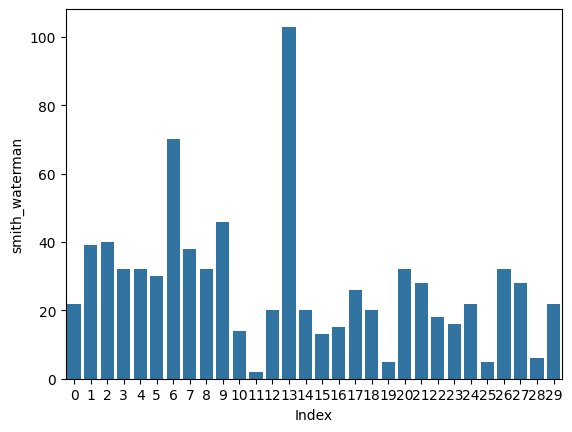

In [218]:
sns.barplot(x=prescription_result.index, y=prescription_result["smith_waterman"])
plt.xlabel("Index")
plt.show()

In [45]:
def dice_coef(_a, _b):
    return round(2*len(set(_a).intersection(set(_b))) / (len(_a) + len(_b)), 3)

In [37]:
prescription_result["generated_text_string"] = prescription_result["generated_text_string"].progress_apply(lambda x: x.lower())
prescription_result["output_text_string"] = prescription_result["output_text_string"].progress_apply(lambda x: x.lower())

100%|██████████| 30/30 [00:00<?, ?it/s]


In [38]:
prescription_result.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te...",lamotrigine,lamotrigine
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te...",lamotrigine 150mg bd,she is taking lamotrigine 150 mg bd with no si...
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te...",lamotrigine 150mg bd,medication: lamotrigine 150mg bd
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te...",sodium valproate,sodium valproate
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te...",sodium valproate 700mg in the morning,sodium valproate


In [168]:
prescription_result["sorensen_dice_coefficient"] = [dice_coef(s1, s2) for s1, s2 in zip(prescription_result["generated_text_string"], 
                                                                                        prescription_result["output_text_string"])]

In [169]:
prescription_result.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string,sorensen_dice_coefficient
0,Your task is to extract prescription informati...,"{'start_index': '547', 'end_index': '558', 'te...","{'start_index': '514', 'end_index': '525', 'te...","{'start_index': '514', 'end_index': '525', 'te...",lamotrigine,lamotrigine,1.000
1,Your task is to extract prescription informati...,"{'start_index': '802', 'end_index': '858', 'te...","{'start_index': '256', 'end_index': '275', 'te...","{'start_index': '256', 'end_index': '275', 'te...",lamotrigine 150mg bd,she is taking lamotrigine 150 mg bd with no si...,0.286
2,Your task is to extract prescription informati...,"{'start_index': '155', 'end_index': '187', 'te...","{'start_index': '214', 'end_index': '236', 'te...","{'start_index': '214', 'end_index': '236', 'te...",lamotrigine 150mg bd,medication: lamotrigine 150mg bd,0.857
3,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '241', 'te...","{'start_index': '204', 'end_index': '217', 'te...","{'start_index': '204', 'end_index': '217', 'te...",sodium valproate,sodium valproate,1.000
4,Your task is to extract prescription informati...,"{'start_index': '224', 'end_index': '240', 'te...","{'start_index': '240', 'end_index': '260', 'te...","{'start_index': '240', 'end_index': '260', 'te...",sodium valproate 700mg in the morning,sodium valproate,0.500


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

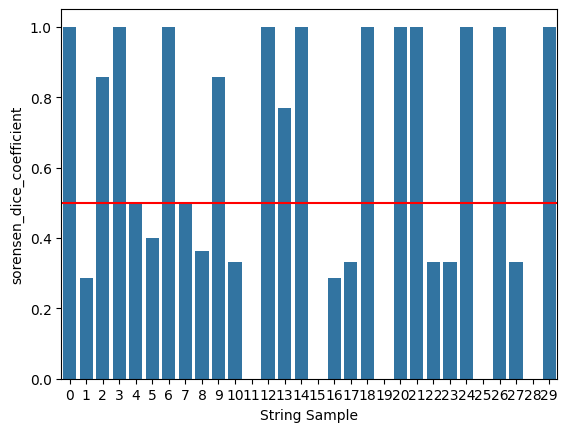

In [170]:
sns.barplot(x=prescription_result.index, y=prescription_result["sorensen_dice_coefficient"])
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
plt.xlabel("String Sample")
plt.show()

In [172]:
error_analysis_data_presc = prescription_result[prescription_result["sorensen_dice_coefficient"] <= 0.0]
error_analysis_data_presc.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string,sorensen_dice_coefficient
11,Your task is to extract prescription informati...,"{'start_index': '103', 'end_index': '117', 'te...","{'start_index': '105', 'end_index': '118', 'te...","{'start_index': '105', 'end_index': '118', 'te...",zonismaide,brivitiracetam,0.0
15,Your task is to extract prescription informati...,"{'start_index': '28', 'end_index': '80', 'text...","{'start_index': '105', 'end_index': '121', 'te...","{'start_index': '105', 'end_index': '121', 'te...",zonisamide : 100mg bd,current medication: levetiracetam 1500mg twice...,0.0
19,Your task is to extract prescription informati...,"{'start_index': '192', 'end_index': '203', 'te...","{'start_index': '80', 'end_index': '89', 'text...","{'start_index': '80', 'end_index': '89', 'text...",topiramate,lamotrigine,0.0
25,Your task is to extract prescription informati...,"{'start_index': '62', 'end_index': '74', 'text...","{'start_index': '154', 'end_index': '167', 'te...","{'start_index': '154', 'end_index': '167', 'te...",levetiracetam to start,lamotrigine,0.0
28,Your task is to extract prescription informati...,"{'start_index': '116', 'end_index': '121', 'te...","{'start_index': '85', 'end_index': '102', 'tex...","{'start_index': '85', 'end_index': '102', 'tex...",epilim 300mg twice a day,eplim,0.0


# Seizure Frequency

In [54]:
sf_data = pd.read_csv("./data/llama_output/seizure_output.csv")
sf_data.head()

,Unnamed: 0,instruction,output,generated_text
0,0,Your task is to extract prescription informati...,"{'start_index': '1060', 'end_index': '1096', '...","{'start_index': '512', 'end_index': '520', 'te..."
1,1,Your task is to extract prescription informati...,"{'start_index': '352', 'end_index': '358', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
2,2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
3,3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te..."
4,4,Your task is to extract prescription informati...,"{'start_index': '232', 'end_index': '239', 'te...","{'start_index': '362', 'end_index': '390', 'te..."


In [60]:
sf_data = sf_data.drop(["Unnamed: 0"], axis=1)
sf_data.head()

,instruction,output,generated_text
0,Your task is to extract prescription informati...,"{'start_index': '1060', 'end_index': '1096', '...","{'start_index': '512', 'end_index': '520', 'te..."
1,Your task is to extract prescription informati...,"{'start_index': '352', 'end_index': '358', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te..."
4,Your task is to extract prescription informati...,"{'start_index': '232', 'end_index': '239', 'te...","{'start_index': '362', 'end_index': '390', 'te..."


In [63]:
sf_data["gemini_flash"] = sf_data["generated_text"].progress_apply(lambda x: get_modified(x))

100%|██████████| 27/27 [04:52<00:00, 10.84s/it]


In [64]:
sf_data.head()

,instruction,output,generated_text,gemini_flash
0,Your task is to extract prescription informati...,"{'start_index': '1060', 'end_index': '1096', '...","{'start_index': '512', 'end_index': '520', 'te...","```json\n{""start_index"": ""512"", ""end_index"": ""..."
1,Your task is to extract prescription informati...,"{'start_index': '352', 'end_index': '358', 'te...","{'start_index': '566', 'end_index': '573', 'te...","```json\n{""start_index"": ""566"", ""end_index"": ""..."
2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te...","```json\n{""start_index"": ""566"", ""end_index"": ""..."
3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te...","```json\n{""start_index"": ""349"", ""end_index"": ""..."
4,Your task is to extract prescription informati...,"{'start_index': '232', 'end_index': '239', 'te...","{'start_index': '362', 'end_index': '390', 'te...","```json\n{""start_index"": ""362"", ""end_index"": ""..."


In [73]:
def fix_sf_data(x):
    return literal_eval(x.replace("json", "").replace("```", "").replace("\n", "").replace("null", "None"))

In [74]:
sf_data["gemini_flash"] = sf_data["gemini_flash"].progress_apply(lambda x: fix_sf_data(x))

sf_data.head()

100%|██████████| 27/27 [00:00<00:00, 34130.86it/s]


,instruction,output,generated_text,gemini_flash
0,Your task is to extract prescription informati...,"{'start_index': '1060', 'end_index': '1096', '...","{'start_index': '512', 'end_index': '520', 'te...","{'start_index': '512', 'end_index': '520', 'te..."
1,Your task is to extract prescription informati...,"{'start_index': '352', 'end_index': '358', 'te...","{'start_index': '566', 'end_index': '573', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te...","{'start_index': '566', 'end_index': '573', 'te..."
3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te...","{'start_index': '349', 'end_index': '357', 'te..."
4,Your task is to extract prescription informati...,"{'start_index': '232', 'end_index': '239', 'te...","{'start_index': '362', 'end_index': '390', 'te...","{'start_index': '362', 'end_index': '390', 'te..."


In [75]:
sf_data.to_csv("sf_result_processed.csv", index=False)

In [79]:
_y_true

array([[1., 1., 1., 1., 1., 1., 1.]])

In [80]:
y_true = np.array([])
y_pred = np.array([])

for _y_pred,  _y_true in zip(sf_data["gemini_flash"], sf_data["output"]):
    _y_true, _y_pred = _convert_to_bool_keys(_y_pred, _y_true)

    if y_true.shape[0] == 0:
        y_true = _y_true
    else:
        y_true = np.vstack((y_true, _y_true))
    
    if y_pred.shape[0] == 0:
        y_pred = _y_pred
    else:
        y_pred = np.vstack((y_pred, _y_pred))

get_metrics(y_true, y_pred)

Exact Match Ratio: 1.0
Hamming loss: 0.00
Recall: 1.0
Precision: 1.00
F1 Measure: 1.00


In [147]:
def pad_single_data(y_data, _y_data):    
    pad_value = y_data.shape[1] - _y_data.shape[1]
    for _ in range(pad_value):
        _y_data = np.append(_y_data, np.array([0]))
    return _y_data.reshape(1, -1)

def pad_multi_data(y_data, _y_data):
    pad_value = _y_data.shape[1] - y_data.shape[1]
    new_y_data = np.zeros((y_data.shape[0], y_data.shape[1] + pad_value))

    i = 0
    for arr in y_data:
        for _ in range(pad_value):
            arr = np.append(arr, np.array([0]))
        new_y_data[i] = arr
        i += 1
    return new_y_data

def pad_data(y_data, _y_data):
    if y_data.shape[1] < _y_data.shape[1]:
        y_data = pad_multi_data(y_data, _y_data)
        return y_data, _y_data
    else:
        _y_data = pad_single_data(y_data, _y_data)
        return y_data, _y_data

y_true = np.array([])
y_pred = np.array([])

for _y_pred, _y_true in zip(sf_data["gemini_flash"], sf_data["output"]): 
    _y_true, _y_pred = _convert_to_bool_values(_y_pred, _y_true)
    if y_true.shape[0] == 0:
        y_true = _y_true
    else:
        y_true, _y_true = pad_data(y_true, _y_true)
        y_true = np.vstack((y_true, _y_true))
    
    if y_pred.shape[0] == 0:
        y_pred = _y_pred
    else:
        y_pred, _y_pred = pad_data(y_pred, _y_pred)
        y_pred = np.vstack((y_pred, _y_pred))

In [149]:
get_metrics(y_pred, y_true)

Exact Match Ratio: 0.0
Hamming loss: 0.30
Recall: 0.5963550852439741
Precision: 1.00
F1 Measure: 0.74


In [150]:
sf_data["generated_text_string"] = sf_data["gemini_flash"].apply(lambda x: x["text"])
sf_data["output_text_string"] = sf_data["output"].apply(lambda x: literal_eval(x)["text"])


sf_data.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string
0,Your task is to extract prescription informati...,"{'start_index': '1060', 'end_index': '1096', '...","{'start_index': '512', 'end_index': '520', 'te...","{'start_index': '512', 'end_index': '520', 'te...",focal to bilateral convulsive seizure,focal to bilateral convulsive seizur
1,Your task is to extract prescription informati...,"{'start_index': '352', 'end_index': '358', 'te...","{'start_index': '566', 'end_index': '573', 'te...","{'start_index': '566', 'end_index': '573', 'te...",seizur,seizur
2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te...","{'start_index': '566', 'end_index': '573', 'te...",seizur,focal motor seizures
3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te...","{'start_index': '349', 'end_index': '357', 'te...",seizure,seizures
4,Your task is to extract prescription informati...,"{'start_index': '232', 'end_index': '239', 'te...","{'start_index': '362', 'end_index': '390', 'te...","{'start_index': '362', 'end_index': '390', 'te...",seizure,seizure


In [166]:
sf_data["sorensen_dice_coefficient"] = [dice_coef(s1, s2) 
                                        for s1, s2 in zip(
                                            sf_data["generated_text_string"], 
                                            sf_data["output_text_string"])]

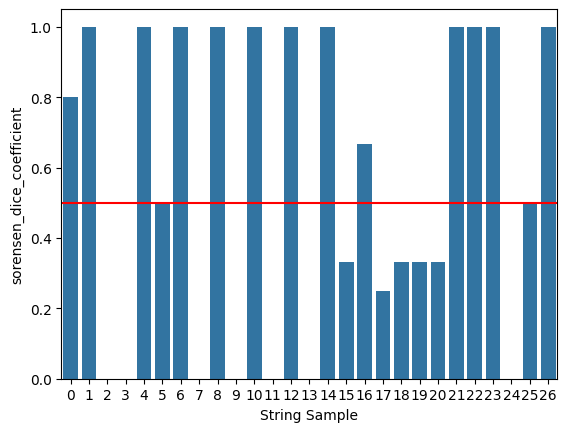

In [167]:
sns.barplot(x=sf_data.index, y=sf_data["sorensen_dice_coefficient"])
plt.axhline(y = 0.5, color = 'r', linestyle = '-') 
plt.xlabel("String Sample")
plt.show()

In [171]:
error_analysis_data = sf_data[sf_data["sorensen_dice_coefficient"] <=0.0]
error_analysis_data.head()

,instruction,output,generated_text,gemini_flash,generated_text_string,output_text_string,sorensen_dice_coefficient
2,Your task is to extract prescription informati...,"{'start_index': '851', 'end_index': '871', 'te...","{'start_index': '566', 'end_index': '573', 'te...","{'start_index': '566', 'end_index': '573', 'te...",seizur,focal motor seizures,0.0
3,Your task is to extract prescription informati...,"{'start_index': '270', 'end_index': '279', 'te...","{'start_index': '349', 'end_index': '357', 'te...","{'start_index': '349', 'end_index': '357', 'te...",seizure,seizures,0.0
7,Your task is to extract prescription informati...,"{'start_index': '175', 'end_index': '212', 'te...","{'start_index': '482', 'end_index': '509', 'te...","{'start_index': '482', 'end_index': '509', 'te...",seizure free,focal seizures with altered awareness,0.0
9,Your task is to extract prescription informati...,"{'start_index': '756', 'end_index': '768', 'te...","{'start_index': '476', 'end_index': '516', 'te...","{'start_index': '476', 'end_index': '516', 'te...",focal seizures with altered awareness,seizure free,0.0
11,Your task is to extract prescription informati...,"{'start_index': '135', 'end_index': '153', 'te...","{'start_index': '373', 'end_index': '401', 'te...","{'start_index': '373', 'end_index': '401', 'te...",seizures,seizure frequency:,0.0


In [162]:
def dice_coef(_a, _b):
    _a = _a.split()
    _b = _b.split()
    string_intersection = set(_a).intersection(set(_b))
    return round(2* (len(string_intersection) / (len(_a) + len(_b))), 3)

In [165]:
_a = "focal to bilateral convulsive seizures"
_b = "focal to bilateral convulsive seizures"

dice_coef(_a, _b)

1.0